In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

ModuleNotFoundError: No module named 'torchvision'

In [2]:
!ls /data/deepfashion2/train/annos | wc -l
!ls /data/deepfashion2/train/image | wc -l
!ls /data/deepfashion2/vaildation/image | wc -l
# !ls ../input/deepfashion2/test_image/image | wc -l

191961
191961
32153


In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "/data/deepfashion2/train/deepfashion2_train.json", "/data/deepfashion2/train/image")
register_coco_instances("deepfashion_val", {}, "/data/deepfashion2/vaildation/deepfashion2_valid.json", "/data/deepfashion2/vaildation/image")

In [6]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion_train",)
#cfg.DATASETS.TEST = ("deepfashion_val",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 8 # 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5000 # 1500
#cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

# cfg.TEST.EVAL_PERIOD = 500

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

ata_time: 0.0298  lr: 0.001  max_mem: 12984M
[06/01 16:41:44 d2.utils.events]:  eta: 1:24:26  iter: 3359  total_loss: 0.5223  loss_cls: 0.2607  loss_box_reg: 0.281  loss_rpn_cls: 0.001119  loss_rpn_loc: 0.006673  time: 2.9696  data_time: 0.0236  lr: 0.001  max_mem: 12984M
[06/01 16:42:44 d2.utils.events]:  eta: 1:23:24  iter: 3379  total_loss: 0.5038  loss_cls: 0.2446  loss_box_reg: 0.2512  loss_rpn_cls: 0.0007044  loss_rpn_loc: 0.009127  time: 2.9698  data_time: 0.0231  lr: 0.001  max_mem: 12984M
[06/01 16:43:42 d2.utils.events]:  eta: 1:22:20  iter: 3399  total_loss: 0.5324  loss_cls: 0.2572  loss_box_reg: 0.2663  loss_rpn_cls: 0.001011  loss_rpn_loc: 0.007622  time: 2.9694  data_time: 0.0299  lr: 0.001  max_mem: 12984M
[06/01 16:44:40 d2.utils.events]:  eta: 1:21:09  iter: 3419  total_loss: 0.5491  loss_cls: 0.2562  loss_box_reg: 0.2684  loss_rpn_cls: 0.0007958  loss_rpn_loc: 0.007315  time: 2.9690  data_time: 0.0252  lr: 0.001  max_mem: 12984M
[06/01 16:45:42 d2.utils.events]:  eta

In [14]:
cfg.MODEL.WEIGHTS = "/data/deepfashion2/models/second_model/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # set threshold for this model
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("deepfashion_val", )
# cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg) # evaluate

In [15]:
im = cv2.imread("/data/img_00000003.jpg") # 치마

outputs = predictor(im)

In [16]:
outputs

{'instances': Instances(num_instances=2, image_height=301, image_width=205, fields=[pred_boxes: Boxes(tensor([[ 57.3118,  74.7930, 162.7348, 170.7755],
         [ 26.3110, 156.8124, 157.5088, 270.5514]], device='cuda:0')), scores: tensor([0.9931, 0.9393], device='cuda:0'), pred_classes: tensor([0, 8], device='cuda:0')])}

In [17]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 8], device='cuda:0')
Boxes(tensor([[ 57.3118,  74.7930, 162.7348, 170.7755],
        [ 26.3110, 156.8124, 157.5088, 270.5514]], device='cuda:0'))


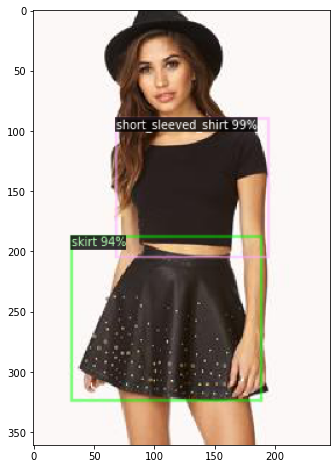

In [40]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=None)
# remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(v.get_image())

In [19]:
import uuid 

boxes = {}
for coordinates in outputs["instances"].to("cpu").pred_boxes:
    coordinates_array = []
    for k in coordinates:
        coordinates_array.append(int(k))
  
    boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
for k,v in boxes.items():
    crop_img = im[v[1]:v[3], v[0]:v[2], :]
    cv2.imwrite(k + '.jpg', crop_img)

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("deepfashion_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "deepfashion_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

r]: Inference done 26296/32153. 0.1365 s / img. ETA=0:13:26
[06/02 04:09:52 d2.evaluation.evaluator]: Inference done 26330/32153. 0.1366 s / img. ETA=0:13:22
[06/02 04:09:57 d2.evaluation.evaluator]: Inference done 26366/32153. 0.1366 s / img. ETA=0:13:17
[06/02 04:10:02 d2.evaluation.evaluator]: Inference done 26407/32153. 0.1365 s / img. ETA=0:13:11
[06/02 04:10:07 d2.evaluation.evaluator]: Inference done 26446/32153. 0.1365 s / img. ETA=0:13:06
[06/02 04:10:12 d2.evaluation.evaluator]: Inference done 26482/32153. 0.1365 s / img. ETA=0:13:01
[06/02 04:10:17 d2.evaluation.evaluator]: Inference done 26519/32153. 0.1365 s / img. ETA=0:12:56
[06/02 04:10:22 d2.evaluation.evaluator]: Inference done 26557/32153. 0.1365 s / img. ETA=0:12:50
[06/02 04:10:27 d2.evaluation.evaluator]: Inference done 26590/32153. 0.1365 s / img. ETA=0:12:46
[06/02 04:10:33 d2.evaluation.evaluator]: Inference done 26626/32153. 0.1366 s / img. ETA=0:12:41
[06/02 04:10:38 d2.evaluation.evaluator]: Inference done 2

OrderedDict([('bbox',
              {'AP': 40.29030662917389,
               'AP50': 54.03975809887226,
               'AP75': 47.36434569610401,
               'APs': 36.41089108910891,
               'APm': 29.82890531619124,
               'APl': 40.44529699037691,
               'AP-short_sleeved_shirt': 67.19358654216467,
               'AP-long_sleeved_shirt': 51.95112058316763,
               'AP-short_sleeved_outwear': 0.0,
               'AP-long_sleeved_outwear': 47.43630889437791,
               'AP-vest': 42.187617988409045,
               'AP-sling': 1.9153993209816342,
               'AP-shorts': 52.555429212597375,
               'AP-trousers': 64.5709362132285,
               'AP-skirt': 52.032216830471434,
               'AP-short_sleeved_dress': 45.3272020830668,
               'AP-long_sleeved_dress': 29.201185594145855,
               'AP-vest_dress': 52.20529403219807,
               'AP-sling_dress': 17.197688884451725})])